In [1]:
import pycalphad
from pycalphad import Database

In [2]:
dbf=Database('uniquac_test_all.xml')
#dbf=Database('CRF3-LIF-mcmc-4.xml')

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_all.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [3]:
print(dbf)

Elements: ['/-', 'C', 'H', 'N', 'VA']
Species: [Species('/-', '/-1'), Species('ACETONITRILE', 'C1.0'), Species('C', 'C1'), Species('H', 'H1'), Species('N', 'N1'), Species('N_HEPTANE', 'H1.0'), Species('VA', 'VA1')]
Phase({'name': 'LIQUID', 'constituents': (frozenset({Species('ACETONITRILE', 'C1.0'), Species('N_HEPTANE', 'H1.0')}),), 'sublattices': (1.0,), 'model_hints': {'uniquac': {}}})
0 symbols in database
9 parameters in database



In [14]:
import copy
import warnings
from symengine import exp, log, Abs, Add, And, Float, Mul, Piecewise, Pow, S, sin, StrictGreaterThan, Symbol, zoo, oo
from tinydb import where
import pycalphad.variables as v
from pycalphad.core.errors import DofError
from pycalphad.core.constants import MIN_SITE_FRACTION
from pycalphad.core.utils import unpack_components, get_pure_elements, wrap_symbol
import numpy as np
from collections import OrderedDict
from tinydb import where
from pycalphad import Model, variables as v
import itertools

In [168]:
class ModelUNIQUAC(Model):
    
    contributions = [
        ("ref", "reference_energy"),
        ("idmix", "ideal_mixing_energy"),
        ("xsmix", "excess_mixing_energy"),
        #("cmbxmix", "combinatorial_contribution_excess_mixing_energy"),
        #("resxmix", "residual_contribution_excess_mixing_energy"),
    ]
    def __init__(self, dbe, comps, phase_name, parameters=None):
        self._dbe = dbe
        self._endmember_reference_model = None
        self.components = set()
        self.constituents = []
        self.phase_name = phase_name.upper()
        phase = dbe.phases[self.phase_name]
        self.site_ratios = list(phase.sublattices)
        active_species = unpack_components(dbe, comps)
        for idx, sublattice in enumerate(phase.constituents):
            subl_comps = set(sublattice).intersection(active_species)
            self.components |= subl_comps

        self.site_ratios = tuple(self.site_ratios)

        # Verify that this phase is still possible to build
        is_pure_VA = set()
        for sublattice in phase.constituents:
            sublattice_comps = set(sublattice).intersection(self.components)
            if len(sublattice_comps) == 0:
                # None of the components in a sublattice are active
                # We cannot build a model of this phase
                raise DofError(
                    '{0}: Sublattice {1} of {2} has no components in {3}' \
                    .format(self.phase_name, sublattice,
                            phase.constituents,
                            self.components))
            is_pure_VA.add(sum(set(map(lambda s : getattr(s, 'number_of_atoms'),sublattice_comps))))
            self.constituents.append(sublattice_comps)
        if sum(is_pure_VA) == 0:
            #The only possible component in a sublattice is vacancy
            #We cannot build a model of this phase
            raise DofError(
                '{0}: Sublattices of {1} contains only VA (VACUUM) constituents' \
                .format(self.phase_name, phase.constituents))
        self.components = sorted(self.components)
        desired_active_pure_elements = [list(x.constituents.keys()) for x in self.components]
        desired_active_pure_elements = [el.upper() for constituents in desired_active_pure_elements
                                        for el in constituents]
        self.pure_elements = sorted(set(desired_active_pure_elements))
        self.nonvacant_elements = [x for x in self.pure_elements if x != 'VA']

        # Convert string symbol names to Symbol objects
        # This makes xreplace work with the symbols dict
        symbols = {Symbol(s): val for s, val in dbe.symbols.items()}

        if parameters is not None:
            self._parameters_arg = parameters
            if isinstance(parameters, dict):
                symbols.update([(wrap_symbol(s), val) for s, val in parameters.items()])
            else:
                # Lists of symbols that should remain symbolic
                for s in parameters:
                    symbols.pop(wrap_symbol(s))
        else:
            self._parameters_arg = None

        self._symbols = {wrap_symbol(key): value for key, value in symbols.items()}

        self.models = OrderedDict()
        self.build_phase(dbe)

        for name, value in self.models.items():
            # XXX: xreplace hack because SymEngine seems to let Symbols slip in somehow
            self.models[name] = self.symbol_replace(value, symbols).xreplace(v.supported_variables_in_databases)

        self.site_fractions = sorted([x for x in self.variables if isinstance(x, v.SiteFraction)], key=str)
        self.state_variables = sorted([x for x in self.variables if not isinstance(x, v.SiteFraction)], key=str)
    @staticmethod


    def __eq__(self, other):
        if self is other:
            return True
        elif type(self) != type(other):
            return False
        else:
            return self.__dict__ == other.__dict__

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(repr(self))

    def moles(self, species, per_formula_unit=False):
        "Number of moles of species or elements."
        species = v.Species(species)
        is_pure_element = (len(species.constituents.keys()) == 1 and
                           list(species.constituents.keys())[0] == species.name)
        result = S.Zero
        normalization = S.Zero
        if is_pure_element:
            element = list(species.constituents.keys())[0]
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(self.components)
                result += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * spec.constituents.get(element, 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        else:
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection({species})
                if len(active) == 0:
                    continue
                result += self.site_ratios[idx] * sum(v.SiteFraction(self.phase_name, idx, spec) for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        if not per_formula_unit:
            return result / normalization
        else:
            return result

    @property
    def ast(self):
        "Return the full abstract syntax tree of the model."
        return Add(*list(self.models.values()))

    @property
    def variables(self):
        "Return state variables in the model."
        return sorted([x for x in self.ast.free_symbols if isinstance(x, v.StateVariable)], key=str)

    @property
    def degree_of_ordering(self):
        result = S.Zero
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content

        site_ratios = [c/site_ratio_normalization for c in self.site_ratios]
        for comp in self.components:
            if comp.number_of_atoms == 0:
                continue
            comp_result = S.Zero
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(set(self.components))
                if comp in active:
                    comp_result += site_ratios[idx] * Abs(v.SiteFraction(self.phase_name, idx, comp) - self.moles(comp)) / self.moles(comp)
            result += comp_result
        return result / sum(int(spec.number_of_atoms > 0) for spec in self.components)
    DOO = degree_of_ordering

    # Can be defined as a list of pre-computed first derivatives
    gradient = None

    # Note: In order-disorder phases, TC will always be the *disordered* value of TC
    curie_temperature = TC = S.Zero
    beta = BMAG = S.Zero
    neel_temperature = NT = S.Zero

    #pylint: disable=C0103
    # These are standard abbreviations from Thermo-Calc for these quantities
    energy = GM = property(lambda self: self.ast)
    formulaenergy = G = property(lambda self: self.ast * self._site_ratio_normalization)
    entropy = SM = property(lambda self: -self.GM.diff(v.T))
    enthalpy = HM = property(lambda self: self.GM - v.T*self.GM.diff(v.T))
    heat_capacity = CPM = property(lambda self: -v.T*self.GM.diff(v.T, v.T))
    #pylint: enable=C0103
    mixing_energy = GM_MIX = property(lambda self: self.GM - self.endmember_reference_model.GM)
    mixing_enthalpy = HM_MIX = property(lambda self: self.GM_MIX - v.T*self.GM_MIX.diff(v.T))
    mixing_entropy = SM_MIX = property(lambda self: -self.GM_MIX.diff(v.T))
    mixing_heat_capacity = CPM_MIX = property(lambda self: -v.T*self.GM_MIX.diff(v.T, v.T))
    @property
    def endmember_reference_model(self):
        """
        Return a Model containing only energy contributions from endmembers.

        Returns
        -------
        Model

        Notes
        -----
        The endmember_reference_model is used for ``_MIX`` properties of Model objects.
        It is defined such that subtracting it from the model will set the energy of the
        endmembers to zero. The endmember_reference_model AST can be modified in the
        same way as any Model.

        Partitioned models have energetic contributions from the ordered compound
        energies/interactions and the disordered compound energies/interactions.
        The endmembers to choose as the reference is ambiguous. If the current model has
        an ordered energy as part of a partitioned model, then the model energy
        contributions are set to ``nan``.

        The endmember reference model is built lazily and stored for later re-use
        because it needs to copy the Database and instantiate a new Model.
        """
        if self._endmember_reference_model is None:
            endmember_only_dbe = copy.deepcopy(self._dbe)
            endmember_only_dbe._parameters.remove(where('constituent_array').test(self._interaction_test))
            mod_endmember_only = self.__class__(endmember_only_dbe, self.components, self.phase_name, parameters=self._parameters_arg)
            # Ideal mixing contributions are always generated, so we need to set the
            # contribution of the endmember reference model to zero to preserve ideal
            # mixing in this model.
            mod_endmember_only.models['idmix'] = 0
            if self.models.get('ord', S.Zero) != S.Zero:
                warnings.warn(
                    f"{self.phase_name} is a partitioned model with an ordering energy "
                    "contribution. The choice of endmembers for the endmember "
                    "reference model used by `_MIX` properties is ambiguous for "
                    "partitioned models. The `Model.set_reference_state` method is a "
                    "better choice for computing mixing energy. See "
                    "https://pycalphad.org/docs/latest/examples/ReferenceStateExamples.html "
                    "for an example."
                )
                for k in mod_endmember_only.models.keys():
                    mod_endmember_only.models[k] = float('nan')
            self._endmember_reference_model = mod_endmember_only
        return self._endmember_reference_model

    def get_internal_constraints(self):
        constraints = []
        # Site fraction balance
        for idx, sublattice in enumerate(self.constituents):
            constraints.append(sum(v.SiteFraction(self.phase_name, idx, spec) for spec in sublattice) - 1)
        # Charge balance for all phases that are charged
        has_charge = len({sp for sp in self.components if sp.charge != 0}) > 0
        constant_site_ratios = True
        # The only implementation with variable site ratios is the two-sublattice ionic liquid.
        # This check is convenient for detecting 2SL ionic liquids without keeping other state.
        # Because 2SL ionic liquids charge balance 'automatically', we do not need to enforce charge balance.
        for sr in self.site_ratios:
            try:
                float(sr)
            except (TypeError, RuntimeError):
                constant_site_ratios = False
        # For all other cases where charge is present, we do need to add charge balance.
        if constant_site_ratios and has_charge:
            total_charge = 0
            for idx, (sublattice, site_ratio) in enumerate(zip(self.constituents, self.site_ratios)):
                total_charge += sum(v.SiteFraction(self.phase_name, idx, spec) * spec.charge * site_ratio
                                    for spec in sublattice)
            constraints.append(total_charge)
        return constraints

    def _array_validity(self, constituent_array):
        """
        Return True if the constituent_array contains only active species of the current Model instance.
        """
        for param_sublattice, model_sublattice in zip(constituent_array, self.constituents):
            if not (set(param_sublattice).issubset(model_sublattice) or (param_sublattice[0] == v.Species('*'))):
                return False
        return True

    def _purity_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has exactly one
        species in every sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return not any(len(sublattice) != 1 for sublattice in constituent_array)

    def _interaction_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has more than one
        species in at least one sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return any([len(sublattice) > 1 for sublattice in constituent_array])

    @property
    def _site_ratio_normalization(self):
        """
        Calculates the normalization factor based on the number of sites
        in each sublattice.
        """
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content
        return site_ratio_normalization
    

    def reference_energy(self, dbe):
        """
        Returns the weighted average of the endmember energies
        in symbolic form.
        """
        pure_energy_term = S.Zero
        pure_param_query = (
            (where('phase_name') == self.phase_name) & \
            (where('parameter_type') == "UQCG") & \
            (where('constituent_array').test(self._purity_test))
        )
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        params = dbe._parameters.search(pure_param_query)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                for param in params:
                    if param['constituent_array'][0][0] == comp:
                        Gref=param["parameter"]
                        energy_term=sitefrac*Gref
                        pure_energy_term+=energy_term
        return pure_energy_term / self._site_ratio_normalization

    def ideal_mixing_energy(self, dbe):
        #pylint: disable=W0613
        """
        Returns the ideal mixing energy in symbolic form.
        """
        phase = dbe.phases[self.phase_name]
        site_ratios = self.site_ratios
        ideal_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            ratio = site_ratios[subl_index]
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                # We lose some precision here, but this makes the limit behave nicely
                # We're okay until fractions of about 1e-12 (platform-dependent)
                mixing_term = Piecewise((sitefrac*log(sitefrac),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
                ideal_mixing_term += (mixing_term*ratio)
        ideal_mixing_term *= (v.R * v.T)
        return ideal_mixing_term / self._site_ratio_normalization
    
    def _rx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        uqcr_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCR") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcr_param_query)
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            for param in params:
                if param["constituent_array"][0][0] == species:
                    r_i=param["parameter"]
                    terms=Piecewise((sitefrac*r_i,
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
        return terms
    
    def _rx_sum(self, dbe):
        rx_sum=S.Zero
        for comp in self.components:
            rx_sum+=self._rx_i(dbe, comp)
        return rx_sum
    
    def _phi_i(self, dbe, species: v.Species):
        return self._rx_i(dbe, species)/self._rx_sum(dbe)
    
    
    def q_i(self, dbe, species: v.Species):
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        uqcq_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCQ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcq_param_query)
        for param in params:
            if param["constituent_array"][0][0] == species:
                 q=param["parameter"]           
        return q
    
    
    def _qx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            terms=sitefrac*self.q_i(dbe, species)
        return terms
    
    def _qx_sum(self, dbe):
        qx_sum=S.Zero
        for comp in self.components:
            qx_sum+=self._qx_i(dbe, comp)
        return qx_sum
    
    def _theta_i(self, dbe, species: v.Species):
        return self._qx_i(dbe, species)/self._qx_sum(dbe)
    
    
    def cmb_p1(self, dbe):
        phase = dbe.phases[self.phase_name]
        ideal_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = sitefrac*log(self._phi_i(dbe,comp)/sitefrac)
                ideal_mixing_term += (mixing_term)
        ideal_mixing_term *= (v.R * v.T)
        return ideal_mixing_term / self._site_ratio_normalization
    
    def Z(self, dbe):
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        uqcz_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCZ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcz_param_query)
        for param in params:
            Z=float(param["parameter"])
        return Z
    
    def cmb_p2(self, dbe):
        phase = dbe.phases[self.phase_name]
        ideal_mixing_term = S.Zero
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = sitefrac*self.q_i(dbe,comp)*log(self._theta_i(dbe,comp)/self._phi_i(dbe,comp))
                ideal_mixing_term += (mixing_term)
        ideal_mixing_term *= (v.R * v.T * self.Z(dbe)/2)
        return ideal_mixing_term / self._site_ratio_normalization
    
    def combinatorial_contribution_excess_mixing_energy(self, dbe):
        Gcmb=self.cmb_p1(dbe)+self.cmb_p2(dbe)
        return Gcmb
    
    def _tau_ji(self, dbe, i: v.Species, j: v.Species):
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        uqct_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCT") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqct_param_query)
        tau_ji=S.Zero
        for param in params:
            if i in param["constituent_array"][0]:
                if j in param["constituent_array"][0]:
                    comps = param["constituent_array"][0]
                    exs = param["exponents"]
                    combination=sorted(zip(exs, comps))
                    for ii in combination:
                        if ii[1] == i:
                            if ii[0]==1:
                                tau_ji=param['parameter']           
        return tau_ji
        
    def _pair_ij(self, dbe, i: v.Species):
        pairs=list(itertools.permutations(self.components, 2))
        i_pair=list()
        for ii in pairs:
            if ii[0] == i:
                i_pair.append(ii)
        return i_pair
                
    
    def _rho_i(self, dbe, i: v.Species):
        phase=dbe.phases[self.phase_name]
        terms=S.Zero
        for i_pair in self._pair_ij(dbe, i):
            ti=i_pair[0]
            tj=i_pair[1]
            tau_ji=self._tau_ji(dbe, ti, tj)
            terms+=tau_ji*self._theta_i(dbe, tj)
        terms+=self._theta_i(dbe, i)
        return terms
    
    def residual_contribution_excess_mixing_energy(self, dbe):
        phase = dbe.phases[self.phase_name]
        ideal_mixing_term = S.Zero
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = sitefrac*self.q_i(dbe,comp)*log(self._rho_i(dbe,comp))
                ideal_mixing_term += (mixing_term)
        ideal_mixing_term *= (v.R * v.T * (-1))
        return ideal_mixing_term / self._site_ratio_normalization
    
    def excess_mixing_energy(self, dbe):
        return self.residual_contribution_excess_mixing_energy(dbe)+self.combinatorial_contribution_excess_mixing_energy(dbe)
        
    def build_phase(self, dbe):
        """
        Generate the symbolic form of all the contributions to this phase.

        Parameters
        ----------
        dbe : 'pycalphad.io.Database'
        """
        self.models.clear()
        for key, value in self.__class__.contributions:
            self.models[key] = S(getattr(self, value)(dbe))

In [96]:
#mod=ModelUNIQUAC(dbf, ['C', 'H', 'N', 'VA'], 'LIQUID')

In [97]:
#print(mod.uniquac)

In [98]:
from pycalphad import Database, equilibrium, variables as v


In [99]:
def comp_convert(x_a):
    x_b=1-x_a
    x_c=(x_a*2+x_b*7)/(x_a*6+x_b*23)
    x_h=(x_a*3+x_b*16)/(x_a*6+x_b*23)
    x_n=(x_a)/(x_a*6+x_b*23)
    return x_c, x_h, x_n

In [100]:
dbf=Database('uniquac_test_all.xml')

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_all.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [101]:
x_a=0.2
X_C, X_H, X_N = comp_convert(x_a)

dbf=Database('uniquac_test_all.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comp=['C', 'H', 'VA']
phase=['LIQUID']
cond={v.N: 1, v.P: 101325, v.T: 400, v.X('H'): 0.5027363}
eq_1 = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)


eq_1.GM.values#*(x_a*6+(1-x_a)*23)



/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_all.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


array([[[[-2305.21909008]]]])

In [102]:
-1718.80340569

-1718.80340569

In [103]:
x_list=np.arange(0.0001, 1, 0.02)

In [104]:
x_list

array([1.000e-04, 2.010e-02, 4.010e-02, 6.010e-02, 8.010e-02, 1.001e-01,
       1.201e-01, 1.401e-01, 1.601e-01, 1.801e-01, 2.001e-01, 2.201e-01,
       2.401e-01, 2.601e-01, 2.801e-01, 3.001e-01, 3.201e-01, 3.401e-01,
       3.601e-01, 3.801e-01, 4.001e-01, 4.201e-01, 4.401e-01, 4.601e-01,
       4.801e-01, 5.001e-01, 5.201e-01, 5.401e-01, 5.601e-01, 5.801e-01,
       6.001e-01, 6.201e-01, 6.401e-01, 6.601e-01, 6.801e-01, 7.001e-01,
       7.201e-01, 7.401e-01, 7.601e-01, 7.801e-01, 8.001e-01, 8.201e-01,
       8.401e-01, 8.601e-01, 8.801e-01, 9.001e-01, 9.201e-01, 9.401e-01,
       9.601e-01, 9.801e-01])

In [105]:
def comp_convert(x_b):
    x_a=1-x_b
    x_c=(x_a*2+x_b*7)/(x_a*6+x_b*23)
    x_h=(x_a*3+x_b*16)/(x_a*6+x_b*23)
    x_n=(x_a)/(x_a*6+x_b*23)
    return x_c, x_h, x_n
GM=[]
xi=[]
x_list=np.arange(0.0001, 1.0, 0.02)
for i in x_list:
    xi.append(i)
xi.append(0.9999)
dbf=Database('uniquac_test_fig1.xml')
for i in xi:
    X_C, X_H, X_N = comp_convert(i)
    cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('H'): i}
    calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)
    GM.append(calc.GM.squeeze().values) 

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_fig1.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [106]:
x_op_fig1=[2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig1=[-3.77E+01, -1.27E+02, -1.99E+02, -2.63E+02, -3.24E+02, -3.81E+02, -4.37E+02, -4.91E+02, -5.43E+02, -5.95E+02, -6.45E+02, -6.94E+02, -7.42E+02, -7.88E+02, -8.34E+02, -8.79E+02, -9.22E+02, -9.65E+02, -1.01E+03, -1.05E+03, -1.08E+03, -1.12E+03, -1.16E+03, -1.20E+03, -1.23E+03, -1.26E+03, -1.30E+03, -1.33E+03, -1.36E+03, -1.38E+03, -1.41E+03, -1.44E+03, -1.46E+03, -1.49E+03, -1.51E+03, -1.53E+03, -1.55E+03, -1.57E+03, -1.59E+03, -1.61E+03, -1.63E+03, -1.64E+03, -1.66E+03, -1.67E+03, -1.68E+03, -1.68E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.70E+03, -1.70E+03, -1.71E+03, -1.72E+03, -1.72E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.74E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.72E+03, -1.71E+03, -1.70E+03, -1.70E+03, -1.69E+03, -1.67E+03, -1.66E+03, -1.65E+03, -1.63E+03, -1.61E+03, -1.60E+03, -1.58E+03, -1.56E+03, -1.53E+03, -1.51E+03, -1.49E+03, -1.46E+03, -1.43E+03, -1.40E+03, -1.37E+03, -1.34E+03, -1.30E+03, -1.27E+03, -1.23E+03, -1.19E+03, -1.15E+03, -1.10E+03, -1.06E+03, -1.01E+03, -9.55E+02, -9.01E+02, -8.44E+02, -7.84E+02, -7.21E+02, -6.54E+02, -5.82E+02, -5.05E+02, -4.23E+02, -3.32E+02, -2.32E+02, -1.14E+02, -8.35E-08]

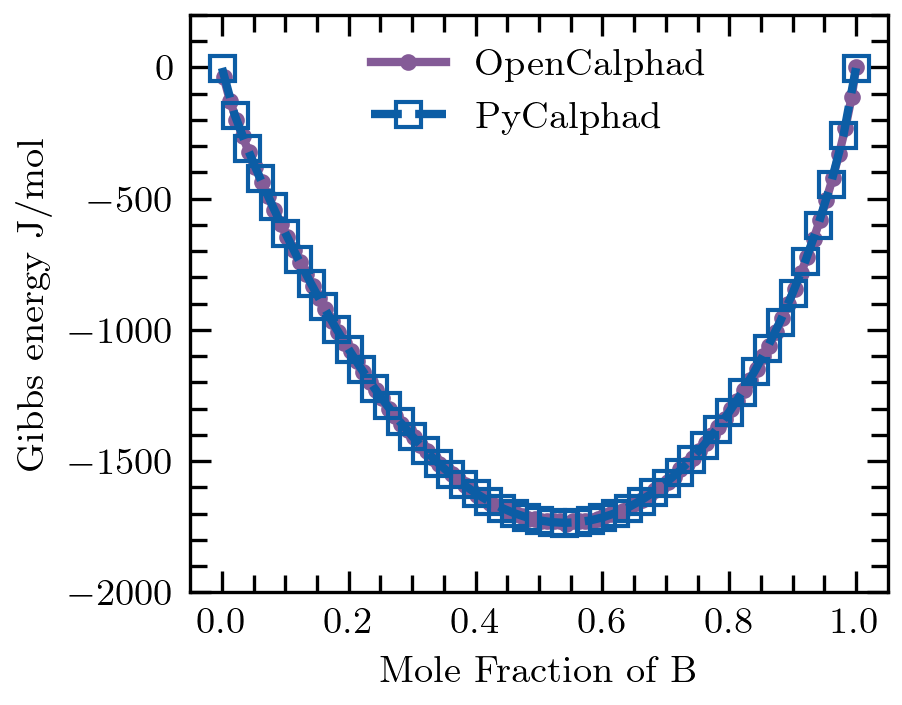

In [107]:
import matplotlib.pyplot as plt
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of B')
fig.gca().set_ylabel('Gibbs energy J/mol')
fig.gca().plot(x_op_fig1, y_op_fig1, 'o-', markersize=3, color='#845B97', label='OpenCalphad')

fig.gca().plot(xi, GM, 's--', markerfacecolor='none', color='#0C5DA5', markersize=6, label='PyCalphad')
fig.gca().set_ylim([-2000, 200])
plt.legend()
plt.savefig('Fig1Py.png', dpi=200)

In [56]:
x_list=np.arange(0.0001, 1, 0.02)
xi=[]
GM=[]
for i in x_list:
    xi.append(i)
xi.append(0.9999)
for i in xi:
    cond = {v.N: 1, v.P: 101325, v.T: 400,  v.X('H'): i}
    calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)
    GM.append(calc.GM.squeeze().values) 

In [80]:
dbf=Database('uniquac_test_all.xml')
x_list=np.arange(0.0001, 1, 0.02)
xi=[]
GM3=[]
for i in x_list:
    xi.append(i)
xi.append(0.9999)
for i in xi:
    cond = {v.N: 1, v.P: 101325, v.T: 400,  v.X('H'): i}
    calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)
    GM3.append(calc.GM.squeeze().values) 

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_all.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [58]:
x_op_fig22=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig22=[-9.70E-08, -4.44E+01, -1.42E+02, -2.11E+02, -2.66E+02, -3.12E+02, -3.50E+02, -3.84E+02, -4.13E+02, -4.39E+02, -4.62E+02, -4.82E+02, -5.00E+02, -5.16E+02, -5.30E+02, -5.43E+02, -5.55E+02, -5.65E+02, -5.74E+02, -5.82E+02, -5.90E+02, -5.96E+02, -6.02E+02, -6.07E+02, -6.12E+02, -6.16E+02, -6.20E+02, -6.23E+02, -6.26E+02, -6.28E+02, -6.31E+02, -6.33E+02, -6.34E+02, -6.36E+02, -6.37E+02, -6.38E+02, -6.39E+02, -6.40E+02, -6.40E+02, -6.41E+02, -6.41E+02, -6.42E+02, -6.42E+02, -6.42E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.42E+02, -6.42E+02, -6.42E+02, -6.41E+02, -6.41E+02, -6.40E+02, -6.39E+02, -6.38E+02, -6.37E+02, -6.36E+02, -6.35E+02, -6.33E+02, -6.31E+02, -6.29E+02, -6.27E+02, -6.24E+02, -6.21E+02, -6.18E+02, -6.14E+02, -6.09E+02, -6.05E+02, -5.99E+02, -5.93E+02, -5.86E+02, -5.78E+02, -5.69E+02, -5.59E+02, -5.49E+02, -5.36E+02, -5.23E+02, -5.08E+02, -4.90E+02, -4.71E+02, -4.50E+02, -4.25E+02, -3.98E+02, -3.66E+02, -3.30E+02, -2.88E+02, -2.37E+02, -1.76E+02, -9.44E+01, -9.70E-08]
x_op_fig21=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig21=[-9.55E-08, -4.07E+01, -1.25E+02, -1.81E+02, -2.23E+02, -2.56E+02, -2.83E+02, -3.05E+02, -3.23E+02, -3.37E+02, -3.49E+02, -3.58E+02, -3.66E+02, -3.72E+02, -3.76E+02, -3.79E+02, -3.81E+02, -3.82E+02, -3.83E+02, -3.83E+02, -3.82E+02, -3.80E+02, -3.78E+02, -3.76E+02, -3.73E+02, -3.71E+02, -3.68E+02, -3.65E+02, -3.61E+02, -3.58E+02, -3.55E+02, -3.51E+02, -3.48E+02, -3.44E+02, -3.41E+02, -3.38E+02, -3.35E+02, -3.32E+02, -3.29E+02, -3.27E+02, -3.24E+02, -3.22E+02, -3.20E+02, -3.18E+02, -3.16E+02, -3.15E+02, -3.14E+02, -3.14E+02, -3.14E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.12E+02, -3.12E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.12E+02, -3.13E+02, -3.14E+02, -3.15E+02, -3.17E+02, -3.19E+02, -3.21E+02, -3.23E+02, -3.25E+02, -3.28E+02, -3.31E+02, -3.34E+02, -3.37E+02, -3.40E+02, -3.43E+02, -3.46E+02, -3.50E+02, -3.53E+02, -3.56E+02, -3.60E+02, -3.63E+02, -3.66E+02, -3.69E+02, -3.72E+02, -3.75E+02, -3.77E+02, -3.79E+02, -3.81E+02, -3.82E+02, -3.83E+02, -3.83E+02, -3.82E+02, -3.80E+02, -3.78E+02, -3.74E+02, -3.69E+02, -3.62E+02, -3.53E+02, -3.43E+02, -3.30E+02, -3.13E+02, -2.94E+02, -2.69E+02, -2.39E+02, -2.01E+02, -1.53E+02, -8.46E+01, -9.55E-08]

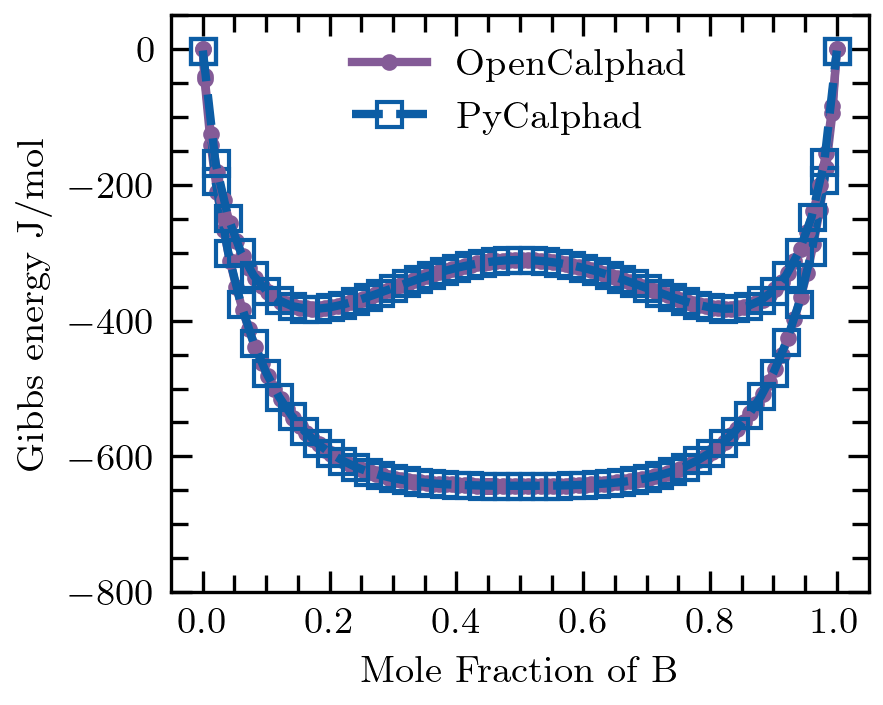

In [84]:
import matplotlib.pyplot as plt
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of B')
fig.gca().set_ylabel('Gibbs energy J/mol')
fig.gca().plot(x_op_fig22, y_op_fig22, 'o-', markersize=3, color='#845B97', label='OpenCalphad')
fig.gca().plot(xi, GM, 's--', markerfacecolor='none', color='#0C5DA5', markersize=6, label='PyCalphad')

fig.gca().plot(x_op_fig21, y_op_fig21, 'o-', markersize=3, color='#845B97')
fig.gca().plot(xi, GM3, 's--', markerfacecolor='none', color='#0C5DA5', markersize=6)

#fig.gca().plot(0.5, G_ref(0.5, T)+G_cmb(0.5, T, rA, rB, qA, qB, z)+G_res(0.5, T, qA, qB, wAB, wBA), 's', markerfacecolor='none', color='#0C5DA5', markersize=6, label='Python Coding')
fig.gca().set_ylim([-800, 50])
plt.legend()
plt.savefig('Fig2Py.png', dpi=200)
plt.show()

In [141]:
dbf=Database('uniquac_test_fig3.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comp=['C', 'H', 'N', 'VA']
phase=['LIQUID']

def comp_convert(x_b):
    x_a=1-x_b
    x_c=(x_a*2+x_b*7)/(x_a*6+x_b*23)
    x_h=(x_a*3+x_b*16)/(x_a*6+x_b*23)
    x_n=(x_a)/(x_a*6+x_b*23)
    return x_c, x_h, x_n
GM=[]
xi=[]
x_list=np.arange(0.0001, 1.0, 0.02)
for i in x_list:
    xi.append(i)
xi.append(0.9999)
for i in xi:
    X_C, X_H, X_N = comp_convert(i)
    cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('C'): X_C, v.X('H'): X_H}
    calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)
    GM.append(calc.GM.squeeze().values*((1-i)*6+i*23)) 

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_fig3.xml:30:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [142]:
def comp_convert(x_b):
    x_a=1-x_b
    x_c=(x_a*2+x_b*7)/(x_a*6+x_b*23)
    x_h=(x_a*3+x_b*16)/(x_a*6+x_b*23)
    x_n=(x_a)/(x_a*6+x_b*23)
    return x_c, x_h, x_n
X_C, X_H, X_N = comp_convert(0.5)
cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('C'): X_C, v.X('H'): X_H}
calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False)


In [143]:
calc

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_C: 1, X_H: 1, vertex: 4, component: 3,
                internal_dof: 2)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 320.0
  * X_C        (X_C) float64 0.3103
  * X_H        (X_H) float64 0.6552
  * vertex     (vertex) int64 0 1 2 3
  * component  (component) <U1 'C' 'H' 'N'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_C, X_H, vertex) float64 1.0 nan nan nan
    GM         (N, P, T, X_C, X_H) float64 -0.02559
    MU         (N, P, T, X_C, X_H, component) float64 -7e+03 ... -1.272e+04
    X          (N, P, T, X_C, X_H, vertex, component) float64 0.3103 ... nan
    Y          (N, P, T, X_C, X_H, vertex, internal_dof) float64 0.5 0.5 ... nan
    Phase      (N, P, T, X_C, X_H, vertex) <U6 'LIQUID' '' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1880+g2a0125b.d20230519
    created:  2023-05-19T20:08:49.104188

In [114]:
GM

[-1.8528654574499535,
 -93.46578180386739,
 -121.7334841164512,
 -130.70240426378095,
 -129.66711121339623,
 -122.86295265582925,
 -112.65890781144455,
 -100.52831989265228,
 -87.44862251605097,
 -74.09635896080388,
 -60.95347051980276,
 -48.369951026227646,
 -36.60300196336244,
 -25.842628164241635,
 -16.22897320189832,
 -7.8643963504873415,
 -0.8220773956938359,
 4.847743833171776,
 9.113183894119967,
 11.957320604762797,
 13.375671164477614,
 13.3743270884769,
 11.968595612501595,
 9.182042516448432,
 5.045863529362421,
 -0.40146495772590085,
 -7.114286982678575,
 -15.039636261791127,
 -24.116876927096367,
 -34.277106656940695,
 -45.44230004474738,
 -57.524154801875156,
 -70.4225851116208,
 -84.0237821523587,
 -98.19772869981355,
 -112.79500877312016,
 -127.64268549641092,
 -142.53892002723055,
 -157.24584986989368,
 -171.47999970691438,
 -184.89909631720644,
 -197.08347246166943,
 -207.50901770478742,
 -215.50631828446825,
 -220.19594629049706,
 -220.37957021487657,
 -214.341348817

In [115]:
x_op_fig3=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig3=[-7.40E-08, -2.67E+01, -7.36E+01, -9.89E+01, -1.14E+02, -1.24E+02, -1.29E+02, -1.31E+02, -1.31E+02, -1.29E+02, -1.26E+02, -1.22E+02, -1.17E+02, -1.11E+02, -1.05E+02, -9.88E+01, -9.23E+01, -8.57E+01, -7.90E+01, -7.23E+01, -6.57E+01, -5.93E+01, -5.29E+01, -4.68E+01, -4.08E+01, -3.51E+01, -2.97E+01, -2.45E+01, -1.96E+01, -1.51E+01, -1.08E+01, -6.86E+00, -3.26E+00, 4.69E-03, 2.92E+00, 5.49E+00, 7.71E+00, 9.57E+00, 1.11E+01, 1.22E+01, 1.30E+01, 1.35E+01, 1.35E+01, 1.33E+01, 1.26E+01, 1.17E+01, 1.12E+01, 1.09E+01, 1.07E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.01E+01, 9.74E+00, 9.41E+00, 8.71E+00, 6.72E+00, 4.40E+00, 1.75E+00, -1.21E+00, -4.50E+00, -8.09E+00, -1.20E+01, -1.62E+01, -2.06E+01, -2.54E+01, -3.04E+01, -3.57E+01, -4.12E+01, -4.70E+01, -5.30E+01, -5.92E+01, -6.56E+01, -7.22E+01, -7.89E+01, -8.59E+01, -9.29E+01, -1.00E+02, -1.07E+02, -1.15E+02, -1.22E+02, -1.30E+02, -1.37E+02, -1.44E+02, -1.52E+02, -1.59E+02, -1.66E+02, -1.73E+02, -1.80E+02, -1.87E+02, -1.93E+02, -1.99E+02, -2.04E+02, -2.09E+02, -2.13E+02, -2.16E+02, -2.19E+02, -2.21E+02, -2.21E+02, -2.20E+02, -2.17E+02, -2.13E+02, -2.06E+02, -1.97E+02, -1.84E+02, -1.66E+02, -1.42E+02, -1.10E+02, -6.26E+01, -7.56E-08]

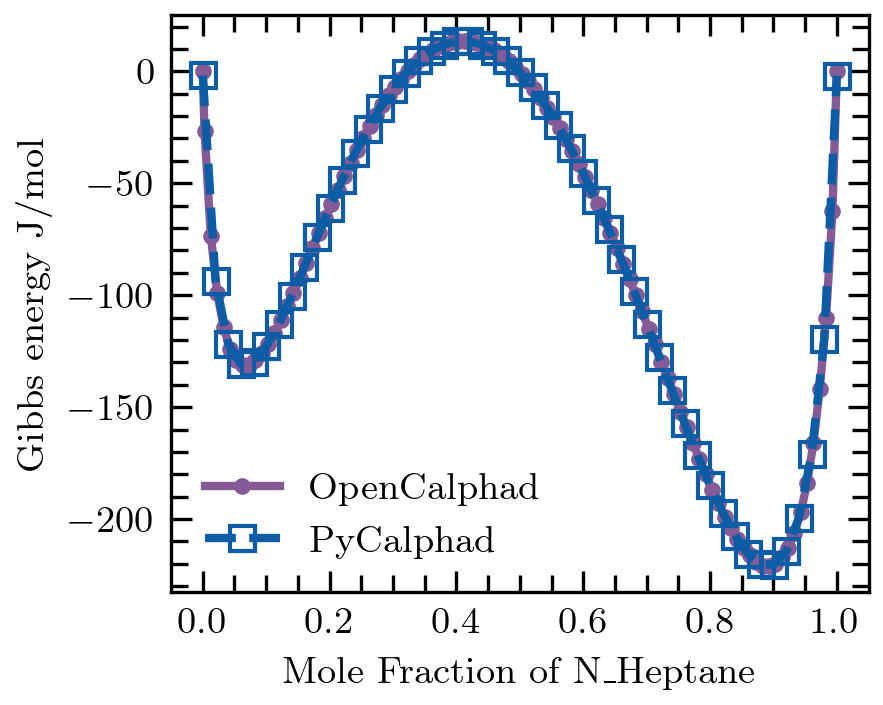

In [118]:

plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of N_Heptane')
fig.gca().set_ylabel('Gibbs energy J/mol')
fig.gca().plot(x_op_fig3, y_op_fig3, 'o-', markersize=3, color='#845B97', label='OpenCalphad')
fig.gca().plot(xi, GM, 's--', markerfacecolor='none', color='#0C5DA5', markersize=6, label='PyCalphad')
#fig.gca().set_ylim([-2000, 200])
plt.legend()
plt.savefig('Fig3Py.png', dpi=200)

In [169]:
dbf=Database('uniquac_test_fig4.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comp=['C', 'H', 'VA']
phase=['LIQUID']

MU=[]
xi=[]
x_list=np.arange(0.0001, 1.0, 0.02)
for i in x_list:
    xi.append(i)
xi.append(0.9999)
for i in xi:
    cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('H'): i}
    calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False, output='MU')
    MU.append(calc.MU.squeeze().values[1]) 

/Users/thea/Desktop/DOE%20NEUP%2022/pycalphad-dev/UNIQUAC/uniquac_test_fig4.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


In [170]:
cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('H'): 0.5}
calc = equilibrium(dbf, comp, phase, cond, model=models, verbose=False, output='MU')

In [171]:
calc.MU.sel(component='C').squeeze()

<xarray.DataArray 'MU' ()>
array(-14761.81801968)
Coordinates:
    N          float64 1.0
    P          float64 1.013e+05
    T          float64 320.0
    X_H        float64 0.5
    component  <U1 'C'

In [172]:
MU[-1]

4.256873045619106

In [173]:
acr=[]
for mu in MU:
    a = exp((mu - MU[-1])/(8.3145*320))
    acr.append(a)

In [174]:
acr

[7.04576406990151e-05,
 0.0342254456278819,
 0.151398029742507,
 0.46497758169595,
 1.18126638538501,
 2.63270426147054,
 5.29806616068892,
 9.79499239056976,
 16.8331827419451,
 27.1251090951266,
 41.2632380688932,
 59.5846858788836,
 82.0517145769348,
 108.176585320905,
 137.011538778856,
 167.211198594061,
 197.159339165512,
 225.13888787433,
 249.516384108989,
 268.911206325236,
 282.325099609677,
 289.216869579306,
 289.517921021638,
 283.594155911699,
 272.166879221877,
 256.209020716337,
 236.833280222429,
 215.18648194883,
 192.360518498908,
 169.325820141953,
 146.889143055954,
 125.674177785167,
 106.121278535074,
 88.5014985725702,
 72.9399141233978,
 59.4436741906745,
 47.9310593995212,
 38.2588358225116,
 30.2461739143395,
 23.694255593007,
 18.4013582562932,
 14.1736710394511,
 10.8323830520855,
 8.21771878243776,
 6.19062098540546,
 4.63273330068175,
 3.44524509996705,
 2.54705386500515,
 1.87259263628875,
 1.36957220339765,
 1.0]

In [247]:
from tinydb import where
from pycalphad import Model, variables as v

class ModelUNIQUAC(Model):
    
    def build_phase(self, dbe):
        super(ModelUNIQUAC, self).build_phase(dbe)
        self.uniquac = self.build_uniquac(dbe)
    
    def q_i(self, dbe, species: v.Species):
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        uqcq_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCQ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcq_param_query)
        for comp in self.components:
            for param in params:
                if param["constituent_array"][0][0] == comp:
                    q=param["parameter"]
        return q
    
    
    def _qx_i(self, dbe, species: v.Species):
        terms=0
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            terms=sitefrac*self.q_i(dbe, species)
        return terms
    
    def _qx_sum(self, dbe):
        phase=dbe.phases[self.phase_name]
        qx_sum=0
        for comp in self.components:
            qx_sum+=self._qx_i(dbe, comp)
        return qx_sum
    
    def _theta_i(self, dbe, species: v.Species):
        return self._qx_i(dbe, species)/self._rx_sum(dbe)
    
    
    def tau_ji(self, dbe, species: v.Species):
        phase=dbe.phases[self.phase_name]
        param_search = dbe.search
        uqcq_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCT") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcq_param_query)
        
        
        return ideal_mixing_term / self._site_ratio_normalization

    
    def cmb_p2(self, dbe):
        phase = dbe.phases[self.phase_name]
        ideal_mixing_term = 0
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = sitefrac*self.q_i(dbe,comp)*log(self._theta_i(dbe,comp)/self._phi_i(dbe,comp))
                ideal_mixing_term += (mixing_term)
        ideal_mixing_term *= self.Z(dbe)/2
        return ideal_mixing_term / self._site_ratio_normalization
    
    def build_uniquac(self, dbe):
       
        return self.cmb_p2(dbe)

      
    
    

In [248]:

dbf=Database('uniquac_test_all.xml')
mod=ModelUNIQUAC(dbf, ['C', 'H', 'N', 'VA'], 'LIQUID')
print(mod.uniquac)

/Users/thea/Desktop/DOE%20NEUP%2022/UNIQUAC/uniquac_test_all.xml:27:0:ERROR:RELAXNGV:RELAXNG_ERR_EXTRACONTENT: Element Phase has extra content: Parameter


5.0*(8.27609254317869*LIQUID0ACETONITRILE - 0.835101617312698*LIQUID0N_HEPTANE)/(1.0*LIQUID0ACETONITRILE + 1.0*LIQUID0N_HEPTANE)


array([[[[[-1790.64176171]]]]])